# **Import Required Packages**

In [1]:
import numpy as np
import scipy.io
import sklearn.metrics
import sklearn 
import os
import random
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential

from keras import initializers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

## **In this model, we will be using the coordinates of the fiducial points only. And view the coordinates as the unsupervised learning to learn the pattern first using autoencoder combining encoder and decoder. Then map the coordinates with the label using softmax dense layers.** 

# **Read the files**


In [6]:
# When using Colab, you can upload train_set.zip in the content folder and run this kernel.
!unzip -qq /content/train_set.zip 

In [7]:
# Set your directory to read the data, default is the directory in colab.
unzipped_folder_path = '/content/train_set'

In [8]:
def read_data_cords(unzipped_folder_path):
  
  # read labels
  labels = pd.read_csv(unzipped_folder_path+'/label.csv')
  y= labels['label'].to_numpy()

  # read points
  n = 3000
  for i in range(1,n+1):
    p_path = str(i).zfill(4)+'.mat'
    points_path = os.path.join('/content/train_set/points/', p_path)
    mat = scipy.io.loadmat(points_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords = mat['faceCoordinatesUnwarped'] 
    else:
      cords = mat['faceCoordinates2']
    
    scaler = MinMaxScaler()  
    scaler.fit(cords)
    cords = scaler.transform(cords)

      # Because the coordinates are absolute postion to the images,
      # but we would like to consider the relative position 
      # of the coordinates to the faces. 
      # So, we take the minmaxscaler to scale the cords.

    if i==1:
      cords_all = np.mat(cords.flatten())
    else:
      cords_all = np.append(cords_all, np.mat(cords.flatten()), axis = 0)
  
  return (cords_all, y)


In [9]:
read_time_start=time.time()
Cord_Ori_X, Ori_Y = read_data_cords(unzipped_folder_path)
print("Read the original dataset takes %s seconds" % round((time.time() - read_time_start),3))

Read the original dataset takes 2.735 seconds


In [10]:
Cord_Ori_X.shape, Ori_Y.shape 
# should be (3000,156) and (3000,) 
# which means 3000 number of cases 
# and 156 numbers of two corrdinates 
# of 78 fiducial points. 
# 156 = 78*2

((3000, 156), (3000,))

# **Data Preprocessing For the Imbalanced Dataset & Generate New Data to Improve Learning Accuracy** 
## From the following analysis, we found that the Original Dataset is unbalanced. So we decided to generate new data for the class with smaller number of original samples. By generating new data, we not only balanced the data with equal number of samples in different class, but also create new data to help improve the learning accuracy.

* Because the number of Class 1 samples is less than the number of Class 0 samples, we decided to add more data in Class 1.
* The way we generate more data is that we randomly select two original cordinates of fiducial points in Class 1 and average them to generate new data of fiducial points and give it the label of 1. 
* It would make sense cause our models believe that the fiducial points in the same class will generate similar patterns of the points.

In [11]:
# Analyzing the data
n = Ori_Y.shape[0]
print('The number of class 0 is ' + str(n-sum(Ori_Y)))
print('The number of class 1 is ' + str(sum(Ori_Y)))
print('Only %.2f'% (sum(Ori_Y)/n*100) + '% of total dataset are class 1.')
print('So, it is an unbalanced dataset, we need to do some data preprocessing.')
print('Here, we are using oversampling to generate more class 1 datasets.')

The number of class 0 is 2402
The number of class 1 is 598
Only 19.93% of total dataset are class 1.
So, it is an unbalanced dataset, we need to do some data preprocessing.
Here, we are using oversampling to generate more class 1 datasets.


In [12]:
def data_preprocessing(Ori_X, Ori_Y, unzipped_folder_path):

  # data preprocessing

  cords_all = Ori_X
  y = Ori_Y

  n = y.shape[0]
  mat_1 = np.add(np.where(y == 1),1)
  n_oversample = (n-sum(y))-sum(y) 
    # how many samples do we need to generate

  for i in range(n_oversample):
    samples_index = random.sample(list(list(mat_1)[0]), 2)
      # pick two random index of class 1 samples. 

    p_path = str(samples_index[0]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_0 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_0 = mat['faceCoordinates2']

    p_path = str(samples_index[1]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_1 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_1 = mat['faceCoordinates2']
    
    cords_new = (cords_0 + cords_1) / 2
        # averaging two sets of cordinates to generate new set of cordinates
        
        # Because the coordinates are absolute postion to the images,
        # but we would like to consider the relative position 
        # of the coordinates to the faces. 
        # So, we take the minmaxscaler to scale the cords.
    scaler = MinMaxScaler()
    scaler.fit(cords_new)
    cords_new = scaler.transform(cords_new)

    cords_all = np.append(cords_all, np.mat(cords_new.flatten()), axis = 0)
    y = np.append(y,np.array(1))
      # Append new data to the original dataset

  return (cords_all, y) 


In [13]:
Cord_Balanced_X, Balanced_Y = data_preprocessing(Cord_Ori_X, Ori_Y, unzipped_folder_path)

In [14]:
Cord_Balanced_X.shape,Balanced_Y.shape

((4804, 156), (4804,))

# Data Scaling and Train Test Split

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Cord_Balanced_X, Balanced_Y,
                                                                            test_size=0.2,
                                                                            random_state=123)

# Build The Autoencoder Model To learn The Pattern Of Fiducial Points 

In [16]:
# build the autoencoder
encoder = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),                                
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu')
      ])
decoder = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(156, activation='sigmoid')
      ])
autoencoder = tf.keras.models.Sequential([
      encoder,
      decoder
      ])

In [17]:
def rounded_accuracy(y_true, y_pred):
  return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
autoencoder.compile(optimizer=tf.keras.optimizers.SGD(1.5),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[rounded_accuracy])

In [19]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

# Train The Model

In [20]:
start_time = time.time()
history = autoencoder.fit(X_train, X_train, batch_size=32, epochs=100, 
                          validation_data = (X_test, X_test),
                          callbacks=[early_stopping_cb])
print("Training the autoencoder model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/100
121/121 [==============================] - 0s 4ms/step - loss: 0.5291 - rounded_accuracy: 0.9389 - val_loss: 0.5124 - val_rounded_accuracy: 0.9704
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5106 - rounded_accuracy: 0.9713 - val_loss: 0.5120 - val_rounded_accuracy: 0.9667
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5105 - rounded_accuracy: 0.9713 - val_loss: 0.5116 - val_rounded_accuracy: 0.9533
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5105 - rounded_accuracy: 0.9712 - val_loss: 0.5115 - val_rounded_accuracy: 0.9704
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5105 - rounded_accuracy: 0.9715 - val_loss: 0.5114 - val_rounded_accuracy: 0.9706
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5105 - rounded_accuracy: 0.9714 - val_loss: 0.5113 - val_rounded_accuracy: 0.9679
Epoch 7/100
121/121 [=========================

# Plot The History Of Training

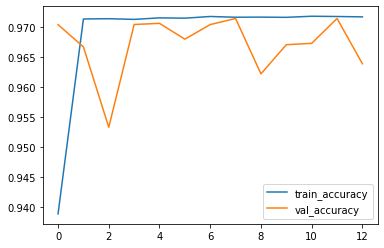

In [21]:
his_plot = pd.DataFrame(history.history)
plt.plot(his_plot['rounded_accuracy'],label = 'train_accuracy')
plt.plot(his_plot['val_rounded_accuracy'], label = 'val_accuracy')
plt.legend()

# Build The Model Of Classification To Map The Learned Pattern To The Catagories.

In [22]:
classification = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
])
encoder.trainable = False # set pretrained encoder to be fixed.

# Train The Model Of Classification

In [26]:
y_train_class = tf.one_hot(y_train, depth=2)
y_test_class = tf.one_hot(y_test, depth=2)

classification.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.AUC()])

start_time = time.time()
history_class = classification.fit(X_train, y_train_class, batch_size=8, epochs=100, 
                          validation_data = (X_test, y_test_class),
                          callbacks=[early_stopping_cb])
print("Training the classification model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/100
481/481 [==============================] - 1s 2ms/step - loss: 0.6944 - auc_2: 0.4992 - val_loss: 0.6935 - val_auc_2: 0.5038
Epoch 2/100
481/481 [==============================] - 1s 1ms/step - loss: 0.6938 - auc_2: 0.5004 - val_loss: 0.6923 - val_auc_2: 0.5233
Epoch 3/100
481/481 [==============================] - 1s 1ms/step - loss: 0.6933 - auc_2: 0.5093 - val_loss: 0.6925 - val_auc_2: 0.5162
Epoch 4/100
481/481 [==============================] - 1s 1ms/step - loss: 0.6937 - auc_2: 0.4890 - val_loss: 0.6932 - val_auc_2: 0.5308
Epoch 5/100
481/481 [==============================] - 1s 2ms/step - loss: 0.6934 - auc_2: 0.5010 - val_loss: 0.6953 - val_auc_2: 0.4762
Training the classification model takes 4.472 seconds


# Plot The History of Training

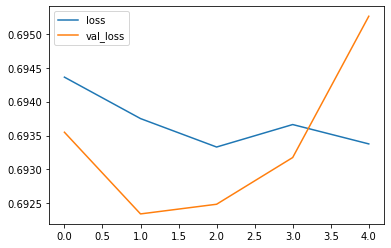

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
his_plot = pd.DataFrame(history_class.history)
plt.plot(his_plot['loss'],label = 'loss')
plt.plot(his_plot['val_loss'], label = 'val_loss')
plt.legend()

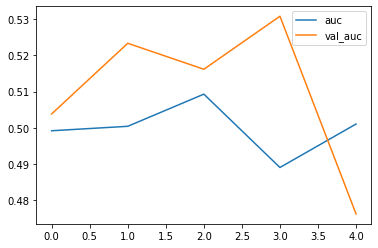

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
his_plot = pd.DataFrame(history_class.history)
plt.plot(his_plot['auc_2'],label = 'auc')
plt.plot(his_plot['val_auc_2'], label = 'val_auc')
plt.legend()

# Evaluate The Model

In [30]:
# Test on the balanced dataset
start_time = time.time()
y_fitprob = classification.predict(X_train)
y_fit = np.argmax(y_fitprob, axis=-1)
print("Testing classification on train_dataset takes %s seconds" % round((time.time() - start_time),3))

start_time = time.time()
y_predprob = classification.predict(X_test)
y_pred = np.argmax(y_predprob, axis=-1)
print("Testing classification on test_dataset takes %s seconds" % round((time.time() - start_time),3))

print("Train dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_train, y_fit))
print("Train dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(y_train_class, y_fitprob))
print("Test dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_test,y_pred))
print("Test dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(y_test_class, y_predprob))

Testing classification on train_dataset takes 0.188 seconds
Testing classification on test_dataset takes 0.053 seconds
Train dataset -- Accuracy:  0.50
Train dataset -- AUC:  0.56
Test dataset -- Accuracy:  0.52
Test dataset -- AUC:  0.55


The autoencoder only shows slightly over 0.5. So this is not a good model for the project.